In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import integrate
import geopy.distance
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import requests
import time
import math

import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

In [2]:
cred = credentials.Certificate('./../Backend/serviceAccount.json')
app_firebase = firebase_admin.initialize_app(cred)
db = firestore.client()

# read data

In [3]:
#แก้
df = {'AIQ3102-1670715240-schedule-0556':{},
      'AIQ3223-1671878940-schedule-0501':{},
      'AIQ3245-1671877800-schedule-0571':{},
      'AIQ3306-1671876960-schedule-0494':{},}

In [4]:
#----- read flight data -----#
for key in df.keys():
    df[key]['df'] = pd.read_csv(f'ONLY_TEST/{key}.csv')
    df[key]['df'].drop(columns=['Unnamed: 0'],inplace=True)


In [5]:
for key in df.keys():
    aircraft = key.split('-')[0]
    print(aircraft)
    doc = db.collection('aircraft_engine').document(f'{aircraft}').get()
    if doc.exists:
        doc = doc.to_dict()
        air_type = doc['type']
        df[key]['ACFT_ID'] = air_type
        print(air_type)
        doc2 = db.collection('NPD_ID').document(f'{air_type}').get()
        if doc2.exists:
            doc2 = doc2.to_dict()
            df[key]['NPD_ID'] = doc2['NPD_ID']
        else: df[key]['NPD_ID']
    else: print('not found',aircraft)
        
        
    doc2 = db.collection('filter_flight').document(f'{key}').get()
    if doc2.exists:
        doc2 = doc2.to_dict()
        period = doc2['period']
        df[key]['period'] = period


AIQ3102


KeyboardInterrupt: 

In [ ]:
df[key].keys()
df[key]['period']

'night'

In [ ]:

df_fix_point = pd.read_csv('data/ANP2.2_Default_fixed_point_profiles.csv',delimiter=';')
df_fix_point = df_fix_point[df_fix_point['Stage Length'] == 1]
df_fix_point = df_fix_point[df_fix_point['Op Type'] == "A"]


change_type = {
    "A320" : "737800",
    "737-800" : "737800"
}
for key in df.keys():
    aircraft_type = df[key]["ACFT_ID"]
    if aircraft_type in change_type:
        aircraft_type = change_type[aircraft_type]
    else:
        df.pop(key)
        continue
    df[key]['df_fix_point'] = df_fix_point[df_fix_point.ACFT_ID == aircraft_type]
    df[key]['df_fix_point'] = df[key]['df_fix_point'].reset_index(drop=True)

In [ ]:
df[key]['df_fix_point']

,ACFT_ID,Op Type,Profile_ID,Stage Length,Point Number,Distance (ft),Altitude AFE (ft),TAS (kt),Power Setting
0,737800,A,DEFAULT,1,1,-144240.0,6000.0,272.3,345.0
1,737800,A,DEFAULT,1,2,-135360.0,5542.0,270.5,332.0
2,737800,A,DEFAULT,1,3,-126540.0,5086.0,268.7,321.0
3,737800,A,DEFAULT,1,4,-113421.0,4405.0,266.1,315.0
4,737800,A,DEFAULT,1,5,-104748.0,3954.0,264.4,312.0
5,737800,A,DEFAULT,1,6,-96133.0,3505.0,262.7,307.0
6,737800,A,DEFAULT,1,7,-87574.0,3059.0,261.0,303.0
7,737800,A,DEFAULT,1,8,-86450.0,3000.0,260.8,303.0
8,737800,A,DEFAULT,1,9,-79300.0,3000.0,243.3,384.0
9,737800,A,DEFAULT,1,10,-71683.0,3000.0,224.1,479.0


# add power setting

In [ ]:
def add_powersetting_2_flight(df_param, df_fixpoint):
    df__tmp = df_fixpoint.copy().groupby('TAS (kt)').max()
    df__tmp = df__tmp.reindex(df__tmp.index.union(df_param.groundspeed.unique()))
    df__tmp = df__tmp.interpolate(method='index',limit_direction='both',limit=200)
    df__tmp = df__tmp.reindex(df_param.groundspeed.unique())
    df__tmp.reset_index(drop=False, inplace=True)
    df__tmp.rename(columns={'TAS (kt)':'groundspeed'}, inplace=True)
    df__tmp = df__tmp[['groundspeed', 'Power Setting']]

    df_param = df_param.merge(df__tmp, how='left', on='groundspeed')
    
    return df_param

In [ ]:
for key in df.keys():
    df[key]['df'] = add_powersetting_2_flight(df[key]['df'], df[key]['df_fix_point'])


In [ ]:
df[key]['df']

,timestamp,fa_flight_id,altitude,groundspeed,heading,latitude,longitude,Power Setting
0,2022-12-12 23:44:43,AIQ512-1670716320-schedule-0609,5.000000,170.0,210.000000,13.895920,100.595270,759.596154
1,2022-12-12 23:44:44,AIQ512-1670716320-schedule-0609,5.437500,170.0,209.937500,13.895302,100.594924,759.596154
2,2022-12-12 23:44:45,AIQ512-1670716320-schedule-0609,5.875000,170.0,209.875000,13.894684,100.594577,759.596154
3,2022-12-12 23:44:46,AIQ512-1670716320-schedule-0609,6.312500,170.0,209.812500,13.894066,100.594231,759.596154
4,2022-12-12 23:44:47,AIQ512-1670716320-schedule-0609,6.750000,170.0,209.750000,13.893448,100.593885,759.596154
...,...,...,...,...,...,...,...,...
226,2022-12-12 23:48:29,AIQ512-1670716320-schedule-0609,87.384615,332.0,177.615385,13.732155,100.422755,345.000000
227,2022-12-12 23:48:30,AIQ512-1670716320-schedule-0609,88.038462,331.5,176.961538,13.730692,100.422838,345.000000
228,2022-12-12 23:48:31,AIQ512-1670716320-schedule-0609,88.692308,331.0,176.307692,13.729228,100.422922,345.000000
229,2022-12-12 23:48:32,AIQ512-1670716320-schedule-0609,89.346154,330.5,175.653846,13.727764,100.423006,345.000000


# creat npd data for flight

In [ ]:
npd = pd.read_csv('data/ANP2.2_NPD_data.csv',delimiter=';', skiprows=[0])
npd.head()

,NPD_ID,Noise Metric,Op Mode,Power Setting,L_200ft,L_400ft,L_630ft,L_1000ft,L_2000ft,L_4000ft,L_6300ft,L_10000ft,L_16000ft,L_25000ft
0,2CF650,EPNL,A,10000.0,106.2,101.1,97.2,92.5,84.2,75.0,68.0,61.4,53.4,43.3
1,2CF650,EPNL,A,25000.0,109.8,105.1,101.5,97.3,90.3,82.0,76.0,70.0,62.7,53.9
2,2CF650,EPNL,D,25000.0,109.8,105.1,101.5,97.3,90.3,82.0,76.0,70.0,62.7,53.9
3,2CF650,EPNL,D,40000.0,113.0,108.6,105.2,101.5,95.6,88.2,83.1,77.5,70.8,63.3
4,2CF650,LAmax,A,10000.0,99.2,91.9,86.7,81.0,72.1,63.0,56.7,49.6,41.6,33.1


In [ ]:
npd.columns

Index(['NPD_ID', 'Noise Metric', 'Op Mode', 'Power Setting', 'L_200ft',
       'L_400ft', 'L_630ft', 'L_1000ft', 'L_2000ft', 'L_4000ft', 'L_6300ft',
       'L_10000ft', 'L_16000ft', 'L_25000ft'],
      dtype='object')

In [ ]:
def get_feet(distance):
    feet = distance.split('_')[1]
    return float(feet[:-2])

In [ ]:
def npd_inter_per_flight(df_param, npd_id):
    npd_of_flight = npd[npd['NPD_ID'] == npd_id]
    npd_of_flight = npd_of_flight[npd_of_flight['Noise Metric'] == 'LAmax']
    npd_of_flight = npd_of_flight[npd_of_flight['Op Mode'] == 'A']
    npd_of_flight.set_index('Power Setting', inplace=True)

    npd_of_flight = npd_of_flight.reindex(npd_of_flight.index.union(df_param['Power Setting'].unique()))
    npd_of_flight = npd_of_flight.interpolate(method='index',limit_direction='both',limit=200)
    
    npd_of_flight = npd_of_flight.drop(columns=['NPD_ID','Noise Metric','Op Mode']).T.reset_index()
    npd_of_flight.rename(columns={'index':'distance'},inplace=True)

    npd_of_flight['distance'] = npd_of_flight['distance'].apply(get_feet)
    npd_of_flight.set_index('distance',inplace=True)
    return npd_of_flight

In [ ]:
for key in df.keys():
    df[key]['npd'] = npd_inter_per_flight(df[key]['df'], df[key]['NPD_ID'])

In [ ]:
# df[key]['npd']

# cal grid

In [ ]:
#----- calculate distance from lat, long -----#
def add_distance(lat1, long1, lat2, long2, h2):
    position1 = (lat1,long1)
    position2 = (lat2,long2)
    a = geopy.distance.geodesic(position1, position2).ft
    b = h2
    b = b*100
    c_square = a**2 + b**2
    c = math.sqrt(c_square)
    return c

In [ ]:
#----- function Single Soung Event -----#
def function_L(sound) :
    return 10**(sound / 10)

In [ ]:
# 13.911475, 100.605997 DMK
# 50 ช่อง -> เพิ่มทีละ 0.004
100.505997, 100.705997
13.811475, 14.011475

(13.811475, 14.011475)

In [ ]:
lat_start =  13.811475
long_start = 100.505997
L_dB_start = 0
size = 50

def create_observerer():
    global lat_start, long_start, L_dB_start
    observer = np.zeros((size,size,3))
    for i in range(size) :
        for j in range(size) :
            observer[i][j] = lat_start, long_start, L_dB_start
            long_start += 0.004
        lat_start  += 0.004
        long_start = 100.505997
    lat_start =  13.811475    
    return observer

In [ ]:
for key in df.keys():
    df[key]['grid'] = create_observerer()

In [ ]:
def Calculate_Grid(observer,df_param, npd_param):
    for i in range(len(observer)):
        for j in range(len(observer[i])): # j = [lat, long, L(dB)]
            #----- copy df_param -----#
            tmp = df_param.copy()
            
            #----- calculate distance every transection -----#
            tmp_distance = []
            tmp['distance'] = -1
            
            for index, row in tmp.iterrows():
                distance = add_distance(observer[i][j][0], observer[i][j][1], row['latitude'], row['longitude'], row['altitude'])
                # print(distance)
                tmp_distance.append(distance)
                tmp.loc[index, 'distance'] = distance
            
            #----- calculate L_dB from powersetting & distance -> copy to model_data -----#
            npd_after_inter = npd_param.reindex(npd_param.index.union(tmp_distance))
            npd_after_inter = npd_after_inter.interpolate(method='index',limit_direction='both',limit=200)
            model_data = npd_after_inter.copy()
            
            #----- add L_dB to df['sound'] & select < 25000 only -----#
            for index, row in tmp.iterrows():
                tmp.loc[index,'sound'] = model_data.loc[row.distance,row['Power Setting']]
                
            tmp = tmp[tmp['distance']<30000]
            
            #----- Single Sound Event Model -----#
            if tmp.empty:
                continue
            tmp['Function'] = tmp['sound'].apply(function_L)
            area = integrate.simpson(tmp['Function'])
            #----- change -inf -> 0 -----#
            if area == 0:
                lSEL = 0
            else:
                lSEL = 10*np.log10( (1/1)*area)
            
            #----- add l_dB to observer -----#
            observer[i][j][2] = lSEL
            
    return observer

In [ ]:
for key in df.keys():
    df[key]['grid'] = Calculate_Grid(df[key]['grid'], df[key]['df'], df[key]['npd'])

In [ ]:
#----- observer to pivot table -----#
for key in df.keys():
    df_tmp = pd.DataFrame(columns = ['Lat','Long','L_dB'])
    
    #----- matrix to pandas -----#
    for i in range(len(df[key]['grid'])):
        row = pd.DataFrame(df[key]['grid'][i], columns = ['Lat','Long','L_dB'])
        df_tmp = pd.concat([df_tmp, row])
    
    #----- Create pivot table -----#
    tabal_df = pd.pivot_table(df_tmp,index='Lat',columns='Long',values='L_dB')
    df[key]['grid'] = tabal_df
    df[key]['grid'] = df[key]['grid'].iloc[::-1]

In [ ]:
df.keys()

dict_keys(['AIQ311-1670716320-schedule-0614', 'AIQ512-1670716320-schedule-0609'])

In [ ]:
df['AIQ512-1670716320-schedule-0609'].keys()

dict_keys(['df', 'ACFT_ID', 'NPD_ID', 'period', 'df_fix_point', 'npd', 'grid'])

In [ ]:
# df['AIQ512-1670716320-schedule-0609']['npd']

In [ ]:
# df['AIQ311-1670716320-schedule-0614']['grid']

Long,100.505997,100.509997,100.513997,100.517997,100.521997,100.525997,100.529997,100.533997,100.537997,100.541997,...,100.665997,100.669997,100.673997,100.677997,100.681997,100.685997,100.689997,100.693997,100.697997,100.701997
Lat,,,,,,,,,,,,,,,,,,,,,
14.007475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
14.003475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
13.999475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
13.995475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
13.991475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
13.987475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
13.983475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
13.979475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
13.975475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [ ]:
# df['AIQ512-1670716320-schedule-0609']['grid'].iloc[::-1]

Long,100.505997,100.509997,100.513997,100.517997,100.521997,100.525997,100.529997,100.533997,100.537997,100.541997,...,100.665997,100.669997,100.673997,100.677997,100.681997,100.685997,100.689997,100.693997,100.697997,100.701997
Lat,,,,,,,,,,,,,,,,,,,,,
13.811475,58.314507,57.841810,57.417217,57.026253,56.673269,56.342914,56.025812,55.732651,55.476293,55.236043,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
13.815475,59.580603,59.131713,58.712178,58.328118,57.966334,57.629175,57.306347,56.988851,56.682158,56.385759,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
13.819475,60.861941,60.441845,60.049209,59.676261,59.328659,58.999998,58.674022,58.360732,58.047174,57.736439,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
13.823475,62.242116,61.795932,61.393110,61.044471,60.714675,60.397077,60.089743,59.779357,59.479054,59.169356,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
13.827475,63.868545,63.422667,62.998632,62.592680,62.202753,61.835682,61.507289,61.217384,60.924044,60.630753,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
13.831475,65.540463,65.137045,64.743548,64.348533,63.953034,63.559885,63.176382,62.804717,62.449527,62.108405,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
13.835475,67.257679,66.857297,66.470542,66.115884,65.749803,65.375126,65.000104,64.627510,64.258325,63.882684,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
13.839475,69.094817,68.797375,68.451700,68.058663,67.633509,67.205612,66.811607,66.473490,66.127145,65.769771,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
13.843475,70.512258,70.439433,70.275605,70.017997,69.682927,69.295427,68.889794,68.488302,68.089850,67.685548,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
tmp_grid = df['AIQ311-1670716320-schedule-0614']['grid'].T
# tmp_grid = df['AIQ512-1670716320-schedule-0609']['grid'].T

# tmp_grid.isnull().sum()

In [ ]:
# tmp_grid

In [ ]:
# for i in tmp_grid.columns:
    # if (tmp_grid[i] == 0).all():
    #     print(f"All values in the column {i} are Zero")
    # print((tmp_grid[i] == -np.inf).sum())

count = np.isinf(tmp_grid).values.sum()
print("It contains " + str(count) + " infinite values")
    



It contains 0 infinite values


In [ ]:
arr = tmp_grid.to_numpy()
# np.argwhere(arr == 0).sum()
np.count_nonzero(arr)

1667

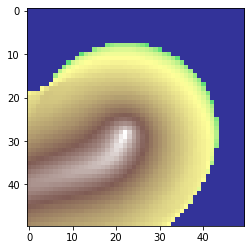

In [ ]:
import matplotlib as mpl
plt.imshow(df['AIQ512-1670716320-schedule-0609']['grid'], cmap='terrain')
plt.show()

In [ ]:
#----- save to csv -----#
for key in df.keys():
    tmp_grid = df[key]['grid'].to_csv(f'grid_flights/{key}.csv', index = True)

# cumulative

In [122]:
#----- result grid for plot -----#
res_grid = np.zeros((5,5))

In [123]:
#----- Variable Value for Cumulative Level ( Day-Night ) -----#
Day_Delta_i = 0
Night_Delta_i = 10
t0 = 1
T0 = 86400

In [124]:
#----- function Cumulative Level ( Day-Night ) -----#
def Cumulative_model(DN, sound):
    global Day_Delta_i, Night_Delta_i
    if DN == 'night':
        return 10**( (sound + Night_Delta_i) / 10 )
    elif DN == 'day':
        return 10**( (sound + Day_Delta_i) / 10 )
    else:
        return 0

In [126]:
for i in range(len(df[list(df.keys())[0]]['grid'])):
    for j in range(len(df[list(df.keys())[0]]['grid'])):
        LDN = 0
        for key in df.keys():
            LDN = LDN + Cumulative_model(df[key]['period'], df[key]['grid'].iloc[i, j])
        res_grid[i][j] = 10*np.log10( (t0 / T0) * LDN )

In [127]:
res_grid

array([[18.92866199, 18.19054901, 17.57295324, 17.03982202, 16.52507032],
       [21.56393447, 20.75828311, 20.0039753 , 19.2965934 , 18.63561802],
       [25.23515807, 24.03293317, 22.96313944, 22.06371979, 21.32778475],
       [30.5172474 , 28.50506842, 27.18390659, 26.02052517, 24.85426043],
       [44.5052504 , 38.09288263, 34.21100867, 31.80339363, 29.72534142]])